    Author(s): DANIEL TWENEBOAH ANYIMADU, TAOFIK AHMED SULEIMAN

# CADx PROJECT: SKIN LESION CLASSIFICATION CHALLENGE USING CLASSICAL MACHINE LEARNING APPROACH 


    - A classical machine learning (ML) approach is employed to addresses both two-class and three-class problems, improving classification accuracy despite huge class imbalances and lesion variations.
    
    - NB: This code is for the three (3) class problem: mel, bcc, scc.

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
from tqdm import tqdm
import random
from sklearn.utils import shuffle

# Libraries for data preprocessing
from skimage import io, exposure, color, feature
from skimage.color import rgb2gray
from skimage.transform import resize

# Libraries for feature extraction
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog  
from skimage.measure import shannon_entropy

# Libraries for training machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, cohen_kappa_score

import warnings 
warnings.filterwarnings('ignore')

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling dataset:**

    Training

In [2]:
#  Define file path
tr_dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Challenge_2/train" # Set path to train folder directory
tr_mel = os.path.join(tr_dir_path, "mel")                                                                                     # Set path to tr_mel folder directory
tr_bcc = os.path.join(tr_dir_path, "bcc")                                                                                     # Set path to tr_bcc folder directory
tr_scc = os.path.join(tr_dir_path, "scc")                                                                                     # Set path to tr_scc folder directory

In [3]:
# Initialize lists to store data
tr_img_names = []; tr_img_file = []; tr_gtruth = []

# For mel images (groundtruth = 0)
for mel_img in tqdm(os.listdir(tr_mel), desc = "mel"):
    tr_img_names.append(mel_img)
    tr_img_file.append(os.path.join(tr_mel, mel_img))
    tr_gtruth.append(0)

# For bcc images (groundtruth = 1)
for bcc_img in tqdm(os.listdir(tr_bcc), desc = "bcc"):
    tr_img_names.append(bcc_img)
    tr_img_file.append(os.path.join(tr_bcc, bcc_img))
    tr_gtruth.append(1)
       
# For scc images (groundtruth = 2)
for scc_img in tqdm(os.listdir(tr_scc), desc = "scc"):
    tr_img_names.append(scc_img)
    tr_img_file.append(os.path.join(tr_scc, scc_img))
    tr_gtruth.append(2)

scc: 100%|██████████| 376/376 [00:00<?, ?it/s]


In [4]:
# Create a dataframe
tr_data = {"tr_img_names":tr_img_names, "tr_img_file":tr_img_file, "tr_gtruth":tr_gtruth}
tr_df = pd.DataFrame(tr_data)
tr_df = shuffle(tr_df).reset_index(drop = True)
tr_df.head()

,tr_img_names,tr_img_file,tr_gtruth
0,scc00357.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2
1,mel01547.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0
2,mel01616.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0
3,scc00038.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,2
4,bcc00765.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,1


    Visualization of training images

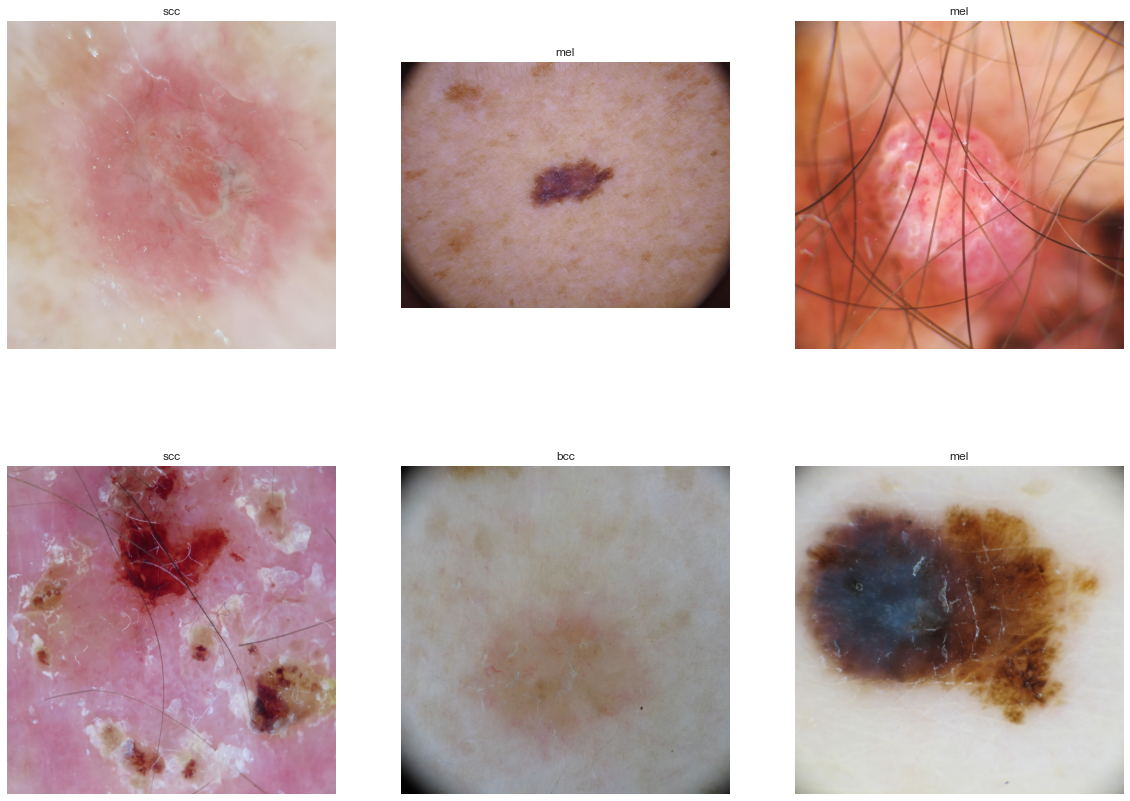

In [5]:
sns.set_style("white")
plt.figure(figsize = [20,15])

for i, (img_path, gnd_truth) in enumerate(zip(tr_df["tr_img_file"][:6], tr_df["tr_gtruth"][:6])): 
    if gnd_truth == 0:
        title = "mel"
    elif gnd_truth == 1: 
        title = "bcc" 
    else:
        title = "scc"
    img_data = cv.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(cv.cvtColor(img_data, cv.COLOR_BGR2RGB))
    plt.axis("off"); plt.title(title)
    
plt.show()

    Validation

In [6]:
#  Define file path
val_dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Challenge_2/val" 
val_mel = os.path.join(val_dir_path, "mel")                                                                                     
val_bcc = os.path.join(val_dir_path, "bcc")                                                                                     
val_scc = os.path.join(val_dir_path, "scc")


# Initialize lists to store data
val_img_names = []; val_img_file = []; val_gtruth = []

# For mel images (groundtruth = 0)
for mel_img in tqdm(os.listdir(val_mel), desc = "mel"):
    val_img_names.append(mel_img)
    val_img_file.append(os.path.join(val_mel, mel_img))
    val_gtruth.append(0)

# For bcc images (groundtruth = 1)
for bcc_img in tqdm(os.listdir(val_bcc), desc = "bcc"):
    val_img_names.append(bcc_img)
    val_img_file.append(os.path.join(val_bcc, bcc_img))
    val_gtruth.append(1)
       
# For scc images (groundtruth = 2)
for scc_img in tqdm(os.listdir(val_scc), desc = "scc"):
    val_img_names.append(scc_img)
    val_img_file.append(os.path.join(val_scc, scc_img))
    val_gtruth.append(2)

    
# Create a dataframe
val_data = {"val_img_names":val_img_names, "val_img_file":val_img_file, "val_gtruth":val_gtruth}
val_df = pd.DataFrame(val_data)
val_df = shuffle(val_df).reset_index(drop = True)
val_df.head()

scc: 100%|██████████| 94/94 [00:00<00:00, 6480.46it/s]


,val_img_names,val_img_file,val_gtruth
0,bcc02061.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,1
1,mel03269.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0
2,mel02952.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0
3,bcc02432.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,1
4,mel02982.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...,0


# DATA PREPROCESSING:

    On training dataset

*Handling Class Imbalance:*

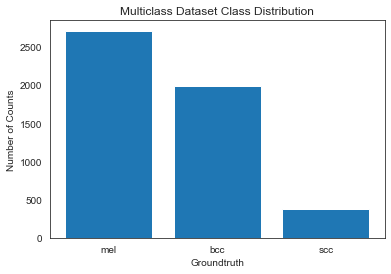

In [7]:
# Plot a bar chart of the class distribution
counts = []
for class_dir in [tr_mel, tr_bcc, tr_scc]:
    counts.append(len(os.listdir(class_dir)))
    
fig, axs = plt.subplots()
axs.bar(["mel", "bcc", "scc"], counts)
plt.title("Multiclass Dataset Class Distribution"); plt.xlabel("Groundtruth"); plt.ylabel("Number of Counts")
plt.show()

    Data augmentation

In [ ]:
# Define data augmentation functions
def central_crop(image, crop_size=(224, 224)):
    h, w, _ = image.shape
    y1 = (h - crop_size[0]) // 2
    y2 = y1 + crop_size[0]
    x1 = (w - crop_size[1]) // 2
    x2 = x1 + crop_size[1]
    cropped = image[y1:y2, x1:x2]
    return cropped

def rescale(image, scale_factor):
    return cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

def enhance_contrast(image, alpha=1.5, beta=0.5):
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)

# Apply data augmentation to train "bcc" and "scc" datasets
random.seed(42)
bcc_samples = tr_df[tr_df["tr_gtruth"] == 1].sample(50)  # 50
scc_samples = tr_df[tr_df["tr_gtruth"] == 2].sample(350) # 350

augmented_data = []
for index, row in pd.concat([bcc_samples, scc_samples]).iterrows():
    img = cv.imread(row['tr_img_file'])
    file_name = os.path.basename(row['tr_img_file'])  # Extract the file name from the image path
    
    # Apply data augmentation techniques
    augmented_images = [central_crop(img),
                        rescale(img, 0.8),    
                        enhance_contrast(img, alpha=1.5, beta=0.5)]
    
    # Save augmented images as image files and store their paths
    augmented_image_paths = []
    for augmented_img in augmented_images:
        augmented_file_name = 'aug_' + file_name
        augmented_path = os.path.join("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Challenge_2/augmented_images", augmented_file_name)
        cv.imwrite(augmented_path, augmented_img)
        augmented_image_paths.append(augmented_path)
    
    # Append the augmented image paths to the dataset with metadata
    for augmented_path in augmented_image_paths:
        augmented_data.append({'tr_img_names': 'aug_' + file_name, 'tr_img_file': augmented_path, 'tr_gtruth': row['tr_gtruth']})

# Append the augmented data to the original dataset
tr_df = pd.concat([tr_df, pd.DataFrame(augmented_data)], ignore_index=True)
tr_df = tr_df.sample(frac=1).reset_index(drop=True)

# Check the updated tr_df
tr_df.tail()

    Display original image with its augmented image

In [ ]:
# # Function to display an image and its corresponding augmented images
# def display_original_and_augmented_images(image_path, augmented_paths):
#     original_image = cv.imread(image_path)
#     augmented_images = [cv.imread(augmented_path) for augmented_path in augmented_paths]

#     plt.figure(figsize=(12, 4))
    
#     # Display the original image
#     plt.subplot(1, len(augmented_images) + 1, 1)
#     plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
#     plt.title("Original")
#     plt.axis("off")
    
#     # Display the augmented images
#     for i, augmented_image in enumerate(augmented_images):
#         plt.subplot(1, len(augmented_images) + 1, i + 2)
#         plt.imshow(cv.cvtColor(augmented_image, cv.COLOR_BGR2RGB))
#         plt.title(f"Augmented {i + 1}")
#         plt.axis("off")
    
#     plt.show()

# # Choose a random image and its augmented images from tr_df
# index = 0  # Change this index as needed
# image_path = tr_df['tr_img_file'].iloc[index]
# augmented_paths = [row['tr_img_file'] for _, row in tr_df[tr_df['tr_img_names'] == 'aug_' + os.path.basename(image_path)].iterrows()]

# # Display the original image and its augmented images
# display_original_and_augmented_images(image_path, augmented_paths)

# FEATURE EXTRACTION

    On training dataset

In [ ]:
# ---: FUNCTIONS FOR FEATURE EXTRACTION
# Define a function to extract color features (HSV and RGB)
def extract_color_features(image):
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    # Extract color statistics
    hsv_mean = np.mean(hsv_image, axis=(0, 1))
    hsv_std = np.std(hsv_image, axis=(0, 1))
    hsv_min = np.min(hsv_image, axis=(0, 1))
    hsv_max = np.max(hsv_image, axis=(0, 1))
    hsv_skewness = skew(hsv_image, axis=(0, 1))
    hsv_kurt = kurtosis(hsv_image, axis=(0,1))
    hsv_entropy = shannon_entropy(hsv_image, base=2)
    
    rgb_mean = np.mean(image, axis=(0, 1))
    rgb_std = np.std(image, axis=(0, 1))
    rgb_min = np.min(image, axis=(0, 1))
    rgb_max = np.max(image, axis=(0, 1))
    rgb_skewness = skew(image, axis=(0, 1))
    rgb_kurt = kurtosis(image, axis=(0,1))
    rgb_entropy = shannon_entropy(image, base=2)
    
    return np.hstack([hsv_mean, hsv_std, hsv_min, hsv_max, hsv_skewness, hsv_kurt, hsv_entropy, rgb_mean, rgb_std, rgb_min, rgb_max, rgb_skewness, rgb_kurt, rgb_entropy])

# Define a function to extract shape features
def extract_shape_features(image):
    gray_image = rgb2gray(image)
    contours, _ = cv.findContours(cv.Canny(cv.convertScaleAbs(gray_image), 50, 150),cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)    
    contour = max(contours, key=cv.contourArea) if contours else np.array([[0, 0]])
    
    perimeter = cv.arcLength(contour, closed=True)
    area = cv.contourArea(contour)
    circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
    compactness = (perimeter ** 2) / (4 * np.pi * area) if area != 0 else 0
    
    moments = cv.moments(contour)
    hu_moments = cv.HuMoments(moments).flatten()
    
    return np.hstack([perimeter, area, circularity, compactness, hu_moments])

# Define a function to extract texture features (GLCM, LBP, Entropy)
radius = [1, 2, 3, 4, 5, 6, 7, 8, 9]  
for r in radius:
    n_points = 8 * r 
def extract_texture_features(image):
    gray_image = rgb2gray(image)
    
    # Specify distances and angles for GLCM
    distances = [2, 5, 7, 10, 15]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances, angles, 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, "contrast")
    homogeneity = graycoprops(glcm, "homogeneity")
    energy = graycoprops(glcm, "energy")
    correlation = graycoprops(glcm, "correlation")
    dissimilarity = graycoprops(glcm, "dissimilarity")
    
    lbp_image = local_binary_pattern(gray_image, n_points, r, method="uniform")
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # entropy = -np.sum(glcm * np.log(glcm + np.finfo(float).eps))
    entropy = shannon_entropy(gray_image)
    
    return np.hstack([contrast.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten(), dissimilarity.flatten(), lbp_hist, entropy])

# Initialize lists to store feature vectors and labels
feature_vectors = []; labels = []

# Loop through each image in the dataframe
for i, row in tqdm(tr_df.iterrows(), total=len(tr_df), desc="Extracting Features"):
    image_path = row["tr_img_file"]
    label = row["tr_gtruth"]

    image = io.imread(image_path)  # Load the image

    # Extract features using defined functions
    color_features = extract_color_features(image)
    shape_features = extract_shape_features(image)
    texture_features = extract_texture_features(image)

    # Combine all features
    combined_features = np.hstack([color_features, shape_features, texture_features])

    feature_vectors.append(combined_features)
    labels.append(label)

# Convert feature vectors and labels to NumPy arrays
X_tr = np.array(feature_vectors)
y_tr = np.array(labels)

In [ ]:
# Define column names for HSV and RGB features
color_feature_names = ["hsv_mean_0", "hsv_mean_1", "hsv_mean_2", "hsv_std_0", "hsv_std_1", "hsv_std_2", "hsv_min_0", "hsv_min_1", "hsv_min_2", "hsv_max_0", "hsv_max_1", "hsv_max_2", "hsv_skewness_0", "hsv_skewness_1", "hsv_skewness_2", "hsv_kurtosis_0", "hsv_kurtosis_1", "hsv_kurtosis_2", "hsv_entropy", "rgb_mean_0", "rgb_mean_1", "rgb_mean_2", "rgb_std_0", "rgb_std_1", "rgb_std_2", "rgb_min_0", "rgb_min_1", "rgb_min_2", "rgb_max_0", "rgb_max_1", "rgb_max_2", "rgb_skewness_0", "rgb_skewness_1", "rgb_skewness_2", "rgb_kurtosis_0", "rgb_kurtosis_1", "rgb_kurtosis_2", "rgb_entropy"]

# Define column names for GLCM properties, LBP, and entropy features
glcm_feature_names = ["contrast_0", "contrast_45", "contrast_90", "contrast_135", "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135", "energy_0", "energy_45", "energy_90", "energy_135", "correlation_0", "correlation_45", "correlation_90", "correlation_135", "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135"]
lbp_feature_names = [f"lbp_hist_{i}" for i in range(158)]  # Adjust the number based on your LBP settings
entropy_feature_name = "entropy"

# Define column names for Hu Moments features
hu_moments_feature_names = [f"hu_moments_{i}" for i in range(7)]

# Modify the all_feature_names list to match the number of columns in X_tr
all_feature_names = color_feature_names + glcm_feature_names + lbp_feature_names + [entropy_feature_name] + hu_moments_feature_names

# Create a new dataframe with feature names as columns and assign feature vectors
feature_df = pd.DataFrame(X_tr, columns=all_feature_names)
feature_df["Label"] = y_tr

# Display the first few rows of the features dataframe
feature_df.head()

In [ ]:
# Save the train extracted features to a CSV file
feature_df.to_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_train_feature", index=False)

    On validation dataset

In [ ]:
# Initialize lists to store feature vectors and labels for validation data
val_feature_vectors = []; val_labels = []

# Loop through each image in the validation dataframe
for i, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Extracting Features (Validation)"):
    image_path = row["val_img_file"]
    label = row["val_gtruth"]

    image = io.imread(image_path)  # Load the image

    # Extract features using defined functions
    color_features = extract_color_features(image)
    shape_features = extract_shape_features(image)
    texture_features = extract_texture_features(image)

    # Combine all features
    combined_features = np.hstack([color_features, shape_features, texture_features])

    val_feature_vectors.append(combined_features)
    val_labels.append(label)
    
# Convert feature vectors and labels to NumPy arrays for validation data
X_val = np.array(val_feature_vectors)
y_val = np.array(val_labels)

In [ ]:
# Define column names for HSV and RGB features
color_feature_names = ["hsv_mean_0", "hsv_mean_1", "hsv_mean_2", "hsv_std_0", "hsv_std_1", "hsv_std_2", "hsv_min_0", "hsv_min_1", "hsv_min_2", "hsv_max_0", "hsv_max_1", "hsv_max_2", "hsv_skewness_0", "hsv_skewness_1", "hsv_skewness_2", "hsv_kurtosis_0", "hsv_kurtosis_1", "hsv_kurtosis_2", "hsv_entropy", "rgb_mean_0", "rgb_mean_1", "rgb_mean_2", "rgb_std_0", "rgb_std_1", "rgb_std_2", "rgb_min_0", "rgb_min_1", "rgb_min_2", "rgb_max_0", "rgb_max_1", "rgb_max_2", "rgb_skewness_0", "rgb_skewness_1", "rgb_skewness_2", "rgb_kurtosis_0", "rgb_kurtosis_1", "rgb_kurtosis_2", "rgb_entropy"]

# Define column names for GLCM properties, LBP, and entropy features
glcm_feature_names = ["contrast_0", "contrast_45", "contrast_90", "contrast_135", "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135", "energy_0", "energy_45", "energy_90", "energy_135", "correlation_0", "correlation_45", "correlation_90", "correlation_135", "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135"]
lbp_feature_names = [f"lbp_hist_{i}" for i in range(158)]  # Adjust the number based on your LBP settings
entropy_feature_name = "entropy"

# Define column names for Hu Moments features
hu_moments_feature_names = [f"hu_moments_{i}" for i in range(7)]

# Modify the all_feature_names list to match the number of columns in X_val
all_feature_names_val = color_feature_names + glcm_feature_names + lbp_feature_names + [entropy_feature_name] + hu_moments_feature_names

# Create a new dataframe with feature names as columns and assign feature vectors
feature_df_val = pd.DataFrame(X_val, columns=all_feature_names_val)
feature_df_val["Label"] = y_val

# Display the first few rows of the features dataframe
feature_df_val.head()

In [ ]:
# Save the validation extracted features to a CSV file
feature_df_val.to_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_validation_feature", index=False)

# EDA ON THE EXTRACTED TRAIN AND VALIDATION FEATURES

In [8]:
# Loading the extracted features (training, validation) to a dataframe
tr_feat = pd.read_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_train_feature.csv")
val_feat = pd.read_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_validation_feature.csv")

In [9]:
tr_feat.shape  # Number of rows and columns
tr_feat.head() # Display the first 5 rows

,hsv_mean_0,hsv_mean_1,hsv_mean_2,hsv_std_0,hsv_std_1,hsv_std_2,hsv_min_0,hsv_min_1,hsv_min_2,hsv_max_0,...,lbp_hist_157,entropy,hu_moments_0,hu_moments_1,hu_moments_2,hu_moments_3,hu_moments_4,hu_moments_5,hu_moments_6,Label
0,153.419264,60.106028,233.326700,41.682339,26.913785,47.022811,0.0,0.0,0.0,179.0,...,3054.0,3044.0,3271.0,3774.0,4865.0,4970.0,19349.0,562200.0,14.376982,1
1,36.668154,109.626258,163.450639,61.766282,37.273756,55.621302,0.0,0.0,0.0,179.0,...,3008.0,3176.0,3166.0,3633.0,4754.0,5184.0,25018.0,534927.0,14.701300,0
2,90.513240,50.340617,167.711267,75.668969,34.917811,56.236797,0.0,0.0,52.0,179.0,...,2953.0,2994.0,3241.0,4061.0,4992.0,5012.0,56563.0,555033.0,14.764857,0
3,32.220626,8.274546,98.642383,49.138404,14.691878,91.652009,0.0,0.0,0.0,179.0,...,1297.0,1492.0,1853.0,3135.0,6528.0,7453.0,95468.0,676816.0,8.555490,1
4,20.097512,88.380493,97.811218,42.459010,34.011981,51.624795,0.0,0.0,26.0,179.0,...,1172.0,1314.0,1732.0,2855.0,5178.0,7669.0,18150.0,749250.0,12.714808,0


In [10]:
val_feat.shape  # Number of rows and columns
val_feat.head() # Display the first 5 rows

,hsv_mean_0,hsv_mean_1,hsv_mean_2,hsv_std_0,hsv_std_1,hsv_std_2,hsv_min_0,hsv_min_1,hsv_min_2,hsv_max_0,...,lbp_hist_157,entropy,hu_moments_0,hu_moments_1,hu_moments_2,hu_moments_3,hu_moments_4,hu_moments_5,hu_moments_6,Label
0,45.689571,34.580357,185.362637,42.726524,40.884670,50.437081,0.0,0.0,1.0,179.0,...,2535.0,2965.0,3554.0,5083.0,6435.0,6297.0,24817.0,681537.0,12.517486,0
1,108.167373,31.007762,161.159335,77.765076,18.196785,25.288351,0.0,0.0,0.0,179.0,...,1431.0,1357.0,1436.0,1941.0,3570.0,5578.0,16204.0,651496.0,12.172382,1
2,124.697083,77.314157,180.658558,74.449725,19.292049,11.931260,0.0,0.0,126.0,179.0,...,3164.0,3528.0,4150.0,5412.0,7350.0,8421.0,32200.0,758614.0,13.525571,1
3,17.377399,96.428398,149.657811,45.128226,12.044058,15.765066,0.0,39.0,6.0,179.0,...,3626.0,3437.0,3409.0,3561.0,5244.0,6812.0,31269.0,623042.0,11.999243,1
4,64.423360,22.376389,173.068326,48.334124,37.516467,48.912311,0.0,0.0,1.0,179.0,...,2079.0,2496.0,3375.0,4983.0,6997.0,7129.0,24153.0,723113.0,11.722601,0


In [11]:
X_tr = tr_feat.drop(columns = "Label", axis = 1)
y_tr = tr_feat["Label"]

X_val = val_feat.drop(columns = "Label", axis = 1)
y_val = val_feat["Label"]

# TRAINING MACHINE LEARNING MODEL WITH EXTRACTED FEATURES

    Applying Feature Engineering: Feature scaling, Feature transformation: (PCA), SelectKBest

    PCA

In [12]:
scaler = StandardScaler()
# Normalizing the
# -----: (1) Training data
X_tr_std = scaler.fit_transform(X_tr)

# -----: (2) Validation data
X_val_std = scaler.transform(X_val)


# Applying PCA on training and validation data
pca = PCA(n_components = 70)
X_tr_pca = pca.fit_transform(X_tr_std)
X_val_pca = pca.transform(X_val_std)

# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200, random_state = 42)
cv_rfc = cross_val_score(rfc, X_tr_pca, y_tr, cv = 5)
rfc.fit(X_tr_pca, y_tr)

y_val_pred = rfc.predict(X_val_pca)
val_acc_rfc = accuracy_score(y_val, y_val_pred)

# Calculate test accuracy
print(f"RFC cross-validation score: {cv_rfc}\n") 
print("RFC training accuracy:", np.mean(cv_rfc))
print(f"\nRFC validation accuracy: {val_acc_rfc}\n")

RFC cross-validation score: [0.81445937 0.83301344 0.81754161 0.82202305 0.83482714]

RFC training accuracy: 0.8243729228157873

RFC validation accuracy: 0.8228346456692913



    SelectKBest

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best = SelectKBest(score_func=f_classif, k=100) # Initialize SelectKBest with the desired number of features (k)
X_tr_kbest = k_best.fit_transform(X_tr_std, y_tr) # Fit SelectKBest on the training data and transform it
X_val_kbest = k_best.transform(X_val_std)         # Transform the validation data using the same feature selection

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
cv_rfc = cross_val_score(rfc, X_tr_kbest, y_tr, cv=5)
rfc.fit(X_tr_kbest, y_tr)

y_val_pred = rfc.predict(X_val_kbest)
val_acc_rfc = accuracy_score(y_val, y_val_pred)

# Calculate test accuracy
print(f"RFC cross-validation score: {cv_rfc}\n")
print("RFC training accuracy:", np.mean(cv_rfc))
print(f"\nRFC validation accuracy: {val_acc_rfc}\n")

C:\Users\dtany\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [38 39 40 41 42 43 44 45 46 47 48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\dtany\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RFC cross-validation score: [0.78950736 0.81829814 0.80153649 0.79513444 0.80089629]

RFC training accuracy: 0.8010745447500334

RFC validation accuracy: 0.7929133858267716



**Machine Learning Models**

    Random Forest:

In [14]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200, random_state = 42)
cv_rfc = cross_val_score(rfc, X_tr_pca, y_tr, cv = 5)
rfc.fit(X_tr_pca, y_tr)

y_val_pred = rfc.predict(X_val_pca)

# Calculate evaluation metrics on validation dataset
print(f"\n----- RANDOM FOREST EVALUATION METRICS -----\n")
print(f"RFC cross-validation score: {cv_rfc}\n")
accuarcy_rfc = accuracy_score(y_val, y_val_pred); print(f"accuracy: {accuarcy_rfc}")                           # Calculate accuracy
precision_rfc = precision_score(y_val, y_val_pred,  average='weighted'); print(f"precision: {precision_rfc}")  # Calculate precision
recall_rfc = recall_score(y_val, y_val_pred,  average='weighted'); print(f"recall: {recall_rfc}")              # Calculate recall
f1_rfc = f1_score(y_val, y_val_pred,  average='weighted'); print(f"f1: {f1_rfc}")                              # Calculate F1-score
bma_rfc = balanced_accuracy_score(y_val, y_val_pred); print(f"bma: {bma_rfc}")                                 # Calculate BMA
kappa_rfc = cohen_kappa_score(y_val, y_val_pred); print(f"kappa score: {kappa_rfc}")                           # Calculate Cohen's Kappa



----- RANDOM FOREST EVALUATION METRICS -----

RFC cross-validation score: [0.81445937 0.83301344 0.81754161 0.82202305 0.83482714]

accuracy: 0.8228346456692913
precision: 0.8138729584803382
recall: 0.8228346456692913
f1: 0.8053069077542319
bma: 0.6282529225670648
kappa score: 0.6704912361623616


    XGBoost:

In [15]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(min_child_weight = 5,max_depth = 12, learning_rate = 0.1, gamma = 0.2, colsample_bytree = 0.7, n_estimators = 200)
cv_xgbc = cross_val_score(xgbc, X_tr_pca, y_tr, cv = 5)
xgbc.fit(X_tr_pca, y_tr)

y_val_pred_xgbc = xgbc.predict(X_val_pca)

# Calculate evaluation metrics on validation dataset
print(f"\n----- XGBClassifier EVALUATION METRICS -----\n")
print(f"XGBoost cross-validation score: {cv_xgbc}\n")
accuarcy_xgbc = accuracy_score(y_val, y_val_pred_xgbc); print(f"accuracy: {accuarcy_xgbc}")                          # Calculate accuracy
precision_xgbc = precision_score(y_val, y_val_pred_xgbc, average='weighted'); print(f"precision: {precision_xgbc}")  # Calculate precision
recall_xgbc = recall_score(y_val, y_val_pred_xgbc, average='weighted'); print(f"recall: {recall_xgbc}")              # Calculate recall
f1_xgbc = f1_score(y_val, y_val_pred_xgbc, average='weighted'); print(f"f1: {f1_xgbc}")                              # Calculate F1-score
bma_xgbc = balanced_accuracy_score(y_val, y_val_pred_xgbc); print(f"bma: {bma_xgbc}")                                # Calculate BMA
kappa_xgbc = cohen_kappa_score(y_val, y_val_pred); print(f"kappa score: {kappa_xgbc}")                               # Calculate Cohen's Kappa



----- XGBClassifier EVALUATION METRICS -----

XGBoost cross-validation score: [0.82725528 0.84836852 0.82330346 0.82714469 0.84891165]

accuracy: 0.8338582677165355
precision: 0.8284460597241281
recall: 0.8338582677165355
f1: 0.8250595940480003
bma: 0.6746661534734937
kappa score: 0.6704912361623616


    Ensemble Model:

In [16]:
from sklearn.ensemble import VotingClassifier

# Create a VotingClassifier ensemble
ensemble_classifier = VotingClassifier(estimators=[('rfc', rfc), ('xgbc', xgbc)], voting='soft')
cv_ensemble_classifier = cross_val_score(ensemble_classifier, X_tr_pca, y_tr, cv = 5)
ensemble_classifier.fit(X_tr_pca, y_tr)

y_val_pred_ensemble = ensemble_classifier.predict(X_val_pca)

# Calculate evaluation metrics on the validation dataset for the ensemble model
print(f"\n----- ENSEMBLE MODEL EVALUATION METRICS -----\n")
print(f"Ensemble cross-validation score: {cv_ensemble_classifier}\n")
accuracy_ensemble = accuracy_score(y_val, y_val_pred_ensemble); print(f"accuracy: {accuracy_ensemble}")                          # Calculate accuracy
precision_ensemble = precision_score(y_val, y_val_pred_ensemble, average='weighted'); print(f"precision: {precision_ensemble}")  # Calculate precision
recall_ensemble = recall_score(y_val, y_val_pred_ensemble, average='weighted'); print(f"recall: {recall_ensemble}")              # Calculate recall
f1_ensemble = f1_score(y_val, y_val_pred_ensemble, average='weighted'); print(f"f1: {f1_ensemble}")                              # Calculate F1-score
bma_ensemble = balanced_accuracy_score(y_val, y_val_pred_ensemble); print(f"bma: {bma_ensemble}")                                # Calculate BMA
kappa_ensemble = cohen_kappa_score(y_val, y_val_pred); print(f"kappa score: {kappa_ensemble}")                                   # Calculate Cohen's Kappa



----- ENSEMBLE MODEL EVALUATION METRICS -----

Ensemble cross-validation score: [0.83237364 0.84644914 0.82522407 0.83290653 0.84635083]

accuracy: 0.8448818897637795
precision: 0.8400331715292344
recall: 0.8448818897637795
f1: 0.8347073516714884
bma: 0.6797385991590791
kappa score: 0.6704912361623616


    K-Nearest Neigbors:

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# K-nearest neighbors (KNN) Classifier
knn = KNeighborsClassifier(n_neighbors = 5)
cv_knn = cross_val_score(knn, X_tr_pca, y_tr, cv=5)
knn.fit(X_tr_pca, y_tr)

y_val_pred_knn = knn.predict(X_val_pca)

# Calculate evaluation metrics on the validation dataset
print(f"\n----- K-nearest Neighbors (KNN) EVALUATION METRICS -----\n")
print(f"KNN cross-validation training accuracy: {cv_knn}\n")
accuracy_knn = accuracy_score(y_val, y_val_pred_knn); print(f"accuracy: {accuracy_knn}")                          # Calculate accuracy
precision_knn = precision_score(y_val, y_val_pred_knn, average='weighted'); print(f"precision: {precision_knn}")  # Calculate precision
recall_knn = recall_score(y_val, y_val_pred_knn, average='weighted'); print(f"recall: {recall_knn}")              # Calculate recall
f1_knn = f1_score(y_val, y_val_pred_knn, average='weighted'); print(f"f1: {f1_knn}")                              # Calculate F1-score
bma_knn = balanced_accuracy_score(y_val, y_val_pred_knn); print(f"bma: {bma_knn}")                                # Calculate BMA
kappa_knn = cohen_kappa_score(y_val, y_val_pred_knn); print(f"kappa score: {kappa_knn}")                          # Calculate Cohen's Kappa



----- K-nearest Neighbors (KNN) EVALUATION METRICS -----

KNN cross-validation training accuracy: [0.75495841 0.77671145 0.76888604 0.74775928 0.76184379]

accuracy: 0.7543307086614173
precision: 0.7439096496290036
recall: 0.7543307086614173
f1: 0.7485700318460811
bma: 0.594422124574366
kappa score: 0.5511615157020975


    Support Vector Machine:

In [18]:
from sklearn.svm import SVC

# Support Vector Machine (SVM) Classifier
svm = SVC(C=1.0, kernel='rbf', random_state=42)
cv_svm = cross_val_score(svm, X_tr_pca, y_tr, cv=5)
svm.fit(X_tr_pca, y_tr)

y_val_pred_svm = svm.predict(X_val_pca)

# Calculate evaluation metrics on the validation dataset
print(f"\n----- Support Vector Machine (SVM) EVALUATION METRICS -----\n")
print(f"SVM cross-validation training accuracy: {cv_svm}")
accuracy_svm = accuracy_score(y_val, y_val_pred_svm); print(f"accuracy: {accuracy_svm}")                          # Calculate accuracy
precision_svm = precision_score(y_val, y_val_pred_svm, average='weighted'); print(f"precision: {precision_svm}")  # Calculate precision
recall_svm = recall_score(y_val, y_val_pred_svm, average='weighted'); print(f"recall: {recall_svm}")              # Calculate recall
f1_svm = f1_score(y_val, y_val_pred_svm, average='weighted'); print(f"f1: {f1_svm}")                              # Calculate F1-score
bma_svm = balanced_accuracy_score(y_val, y_val_pred_svm); print(f"bma: {bma_svm}")                                # Calculate BMA
kappa_svm = cohen_kappa_score(y_val, y_val_pred_svm); print(f"kappa score: {kappa_svm}")                          # Calculate Cohen's Kappa



----- Support Vector Machine (SVM) EVALUATION METRICS -----

SVM cross-validation training accuracy: [0.756238   0.77479207 0.75800256 0.75928297 0.77208707]
accuracy: 0.7803149606299212
precision: 0.7748256618604447
recall: 0.7803149606299212
f1: 0.7750053016353929
bma: 0.6299722205208206
kappa score: 0.6011593876632149


    Multi-Layer Perceptron:

In [19]:
from sklearn.neural_network import MLPClassifier

# Multi-Layer Perceptron (MLP) Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=42)
cv_mlp = cross_val_score(mlp, X_tr_pca, y_tr, cv=5)
mlp.fit(X_tr_pca, y_tr)

y_val_pred_mlp = mlp.predict(X_val_pca)

# Calculate evaluation metrics on the validation dataset
print(f"\n----- MLP CLASSIFIER EVALUATION METRICS -----\n")
print(f"MLP Classifier cross-validation training accuracy: {cv_mlp}")
accuracy_mlp = accuracy_score(y_val, y_val_pred_mlp); print(f"accuracy: {accuracy_mlp}")                          # Calculate accuracy
precision_mlp = precision_score(y_val, y_val_pred_mlp, average='weighted'); print(f"precision: {precision_mlp}")  # Calculate precision
recall_mlp = recall_score(y_val, y_val_pred_mlp, average='weighted'); print(f"recall: {recall_mlp}")              # Calculate recall
f1_mlp = f1_score(y_val, y_val_pred_mlp, average='weighted'); print(f"f1: {f1_mlp}")                              # Calculate F1-score
bma_mlp = balanced_accuracy_score(y_val, y_val_pred_mlp); print(f"bma: {bma_mlp}")                                # Calculate BMA
kappa_mlp = cohen_kappa_score(y_val, y_val_pred_mlp); print(f"kappa score: {kappa_mlp}")                          # Calculate Cohen's Kappa


C:\Users\dtany\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



----- MLP CLASSIFIER EVALUATION METRICS -----

MLP Classifier cross-validation training accuracy: [0.81573896 0.85220729 0.81882202 0.84122919 0.83802817]
accuracy: 0.841732283464567
precision: 0.839909523519906
recall: 0.841732283464567
f1: 0.8406162106650581
bma: 0.7292317452827692
kappa score: 0.7135531217738678


# LEVERAGING THE MODEL BUILT ON THE TEST DATASET

**EXPLORATORY DATA ANALYSIS**

In [20]:
import tarfile
test_archive_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Challenge_2/test.tgz"     # path to the test archive
extracted_dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Challenge_2/test_images" # directory to extract images to

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok = True)

# Extract the images from the archive
with tarfile.open(test_archive_path, "r:gz") as tar:
    tar.extractall(path = extracted_dir_path)

# List image names in the directory
test_img_name = os.listdir(os.path.join(extracted_dir_path, "testX"))

# Sort the image names in ascending order
test_img_name.sort()

# Create a list of dictionaries for each image
test_data = []
for img_name in test_img_name:
    test_img_file = os.path.join(extracted_dir_path, "testX", img_name)
    test_data.append({"test_img_name": img_name, "test_img_file": test_img_file})

# Create a DataFrame from the list of dictionaries
test_df = pd.DataFrame(test_data)
test_df.head()

,test_img_name,test_img_file
0,xxx00001.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
1,xxx00002.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
2,xxx00003.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
3,xxx00004.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...
4,xxx00005.jpg,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SE...


**FEATURE EXTRACTION**

In [ ]:
# Initialize lists to store feature vectors for test data
test_feature_vectors = []

# Loop through each image in the test dataframe
for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Extracting Features (Test)"):
    image_path = row["test_img_file"]

    image = io.imread(image_path)  # Load the image

    # Extract features using defined functions
    color_features = extract_color_features(image)
    shape_features = extract_shape_features(image)
    texture_features = extract_texture_features(image)

    # Combine all features
    combined_features = np.hstack([color_features, shape_features, texture_features])

    test_feature_vectors.append(combined_features)

# Convert feature vectors to NumPy arrays for test data
X_test = np.array(test_feature_vectors)

In [ ]:
# Define column names for HSV and RGB features
color_feature_names = ["hsv_mean_0", "hsv_mean_1", "hsv_mean_2", "hsv_std_0", "hsv_std_1", "hsv_std_2", "hsv_min_0", "hsv_min_1", "hsv_min_2", "hsv_max_0", "hsv_max_1", "hsv_max_2", "hsv_skewness_0", "hsv_skewness_1", "hsv_skewness_2", "hsv_kurtosis_0", "hsv_kurtosis_1", "hsv_kurtosis_2", "hsv_entropy", "rgb_mean_0", "rgb_mean_1", "rgb_mean_2", "rgb_std_0", "rgb_std_1", "rgb_std_2", "rgb_min_0", "rgb_min_1", "rgb_min_2", "rgb_max_0", "rgb_max_1", "rgb_max_2", "rgb_skewness_0", "rgb_skewness_1", "rgb_skewness_2", "rgb_kurtosis_0", "rgb_kurtosis_1", "rgb_kurtosis_2", "rgb_entropy"]

# Define column names for GLCM properties, LBP, and entropy features
glcm_feature_names = ["contrast_0", "contrast_45", "contrast_90", "contrast_135", "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135", "energy_0", "energy_45", "energy_90", "energy_135", "correlation_0", "correlation_45", "correlation_90", "correlation_135", "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135"]
lbp_feature_names = [f"lbp_hist_{i}" for i in range(158)]  # Adjust the number based on your LBP settings
entropy_feature_name = "entropy"

# Define column names for Hu Moments features
hu_moments_feature_names = [f"hu_moments_{i}" for i in range(7)]

# Modify the all_feature_names list to match the number of columns in X_tr (108)
all_feature_names_test = color_feature_names + glcm_feature_names + lbp_feature_names + [entropy_feature_name] + hu_moments_feature_names

# Create a new dataframe with feature names as columns and assign feature vectors
feature_df_test = pd.DataFrame(X_test, columns=all_feature_names_test)

# Display the first few rows of the features dataframe
feature_df_test.head()

In [ ]:
# Save the validation extracted features to a CSV file
feature_df_test.to_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_test_feature", index=False)

**EDA ON THE EXTRACTED TEST FEATURES**

In [21]:
# Loading the extracted features (test) to a dataframe
ts_feat = pd.read_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_test_feature.csv")

ts_feat.shape  # Number of rows and columns
ts_feat.head() # Display the first 5 rows

,hsv_mean_0,hsv_mean_1,hsv_mean_2,hsv_std_0,hsv_std_1,hsv_std_2,hsv_min_0,hsv_min_1,hsv_min_2,hsv_max_0,...,lbp_hist_156,lbp_hist_157,entropy,hu_moments_0,hu_moments_1,hu_moments_2,hu_moments_3,hu_moments_4,hu_moments_5,hu_moments_6
0,73.968722,61.943867,225.151444,83.561901,24.245531,16.739946,0.0,7.0,36.0,179.0,...,610.0,687.0,822.0,984.0,1287.0,1486.0,1265.0,6055.0,176781.0,13.755617
1,140.920557,39.478124,143.898439,44.932436,14.203551,9.016230,0.0,8.0,93.0,179.0,...,1986.0,2075.0,2129.0,2416.0,2981.0,4515.0,6273.0,20248.0,730460.0,12.350693
2,124.654681,30.159830,207.595978,74.898296,14.913045,13.404212,0.0,4.0,28.0,179.0,...,634.0,724.0,835.0,1027.0,1400.0,1680.0,1566.0,6937.0,195190.0,12.109280
3,21.968102,70.042047,157.372159,35.495573,66.872971,32.653270,0.0,0.0,33.0,179.0,...,2160.0,2123.0,2237.0,2336.0,2713.0,3827.0,4890.0,18407.0,588959.0,12.281826
4,7.969683,66.945208,176.197457,17.091695,19.663925,10.258080,0.0,0.0,18.0,179.0,...,1812.0,2367.0,3130.0,4310.0,5354.0,5897.0,5209.0,22868.0,542987.0,10.307015


In [22]:
X_test = ts_feat

**TRAINING MACHINE LEARNING MODEL WITH EXTRACTED FEATURES**

    Applying Feature Engineering: Feature Scaling, PCA

In [24]:
scaler = StandardScaler()
# Normalizing the
# -----: (1) Training data
X_tr_std = scaler.fit_transform(X_tr)

# -----: (3) Test data
X_test_std = scaler.transform(X_test)


# Applying PCA on test data
pca = PCA(n_components = 70)
X_tr_pca = pca.fit_transform(X_tr_std)
X_test_pca = pca.transform(X_test_std)

# Predict the target values for the test dataset
y_test_pred = mlp.predict(X_test_pca)

# Create a DataFrame for the test results
test_results = pd.DataFrame({"image_name": test_df["test_img_name"],"image_label": y_test_pred})
test_results.head()

,image_name,image_label
0,xxx00001.jpg,2
1,xxx00002.jpg,1
2,xxx00003.jpg,1
3,xxx00004.jpg,0
4,xxx00005.jpg,0


In [ ]:
# Save the test results to a CSV file
test_results.to_csv("C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/SEM_3_(SPAIN)/Computer_Aided_Diagnosis/Projects/Classical ML/Features/multi_test_results.csv", index = False)